In [1]:
import numba
import sys
sys.path.insert(0, './python_lib')
import networkx as nx
import numpy as np
import graph_gen
import model
import random
from collections import defaultdict
import torch
import math
import solvers

In [2]:
%matplotlib inline

In [3]:
Degree = 4 # degree
Height =2 # Height of the tree

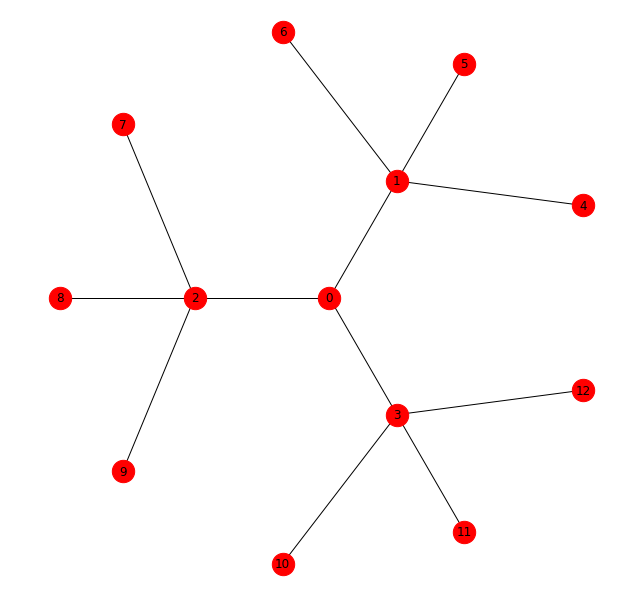

[[12, 2], [1, 7], [5, 8], [4, 9]]


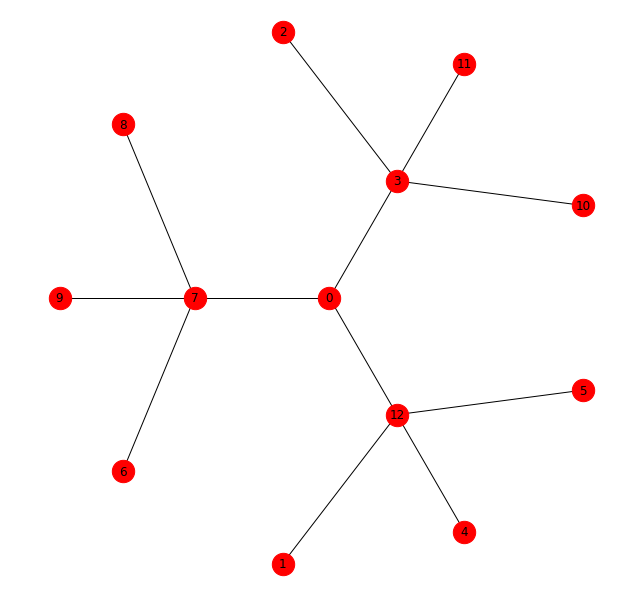

In [4]:
import imp 

import graph_gen
imp.reload(graph_gen)
N, J_interaction = graph_gen.tree_interaction(Degree,Height)

#H = np.random.random(N)
H = np.zeros(N)

num_swap = 4
swaps = []
nodes = list(range(N))
for n in range(num_swap):
    ss_temp = random.sample(nodes, 2)
    swaps.append(ss_temp)
    #print(ss_temp)
    nodes.remove(ss_temp[0])
    nodes.remove(ss_temp[1])
    
print(swaps)

J_interaction_rand = J_interaction.copy()
H_rand = H.copy()

for w in swaps:
    rev = list(reversed(w))
    J_interaction_rand[w] = J_interaction_rand[rev] 
    J_interaction_rand[:,w] = J_interaction_rand[:,rev] 
    H_rand[w] = H_rand[rev]
J_interaction_rand
graph_gen.plot_matrix_graph(J_interaction_rand)

betas = np.arange(1e-6,2,1e-2)
betas_fast = np.arange(1e-6,2,1e-1)

j_start = 1
j = graph_gen.fixed_value(j_start)
J = graph_gen.set_J(J_interaction, j)
J_rand = graph_gen.set_J(J_interaction_rand, j)

#N_rand, J_interaction_rand = graph_gen.tree_interaction(Degree, Height, rand=True)

In [5]:
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)
res_ex = solvers.exact_sol(tree, betas_fast)

beta: 0.0, Fe: -693147.181 Energy: -9.23e-07 M: 6e-19 S: 0.693
beta: 0.1, Fe: -6.977 Energy: -0.092 M: -1.19e-18 S: 0.689
beta: 0.2, Fe: -3.557 Energy: -0.182 M: 2.94e-18 S: 0.675
beta: 0.3, Fe: -2.447 Energy: -0.269 M: 1.13e-17 S: 0.653
beta: 0.4, Fe: -1.913 Energy: -0.351 M: -1.34e-17 S: 0.625
beta: 0.5, Fe: -1.608 Energy: -0.427 M: 0.0 S: 0.591
beta: 0.6, Fe: -1.417 Energy: -0.496 M: -1.77e-17 S: 0.553
beta: 0.7, Fe: -1.290 Energy: -0.558 M: -2.23e-17 S: 0.512
beta: 0.8, Fe: -1.202 Energy: -0.613 M: -1.67e-17 S: 0.471
beta: 0.9, Fe: -1.139 Energy: -0.661 M: -2.91e-17 S: 0.43
beta: 1.0, Fe: -1.094 Energy: -0.703 M: 2.4e-17 S: 0.391
beta: 1.1, Fe: -1.060 Energy: -0.739 M: 5.64e-17 S: 0.353
beta: 1.2, Fe: -1.034 Energy: -0.77 M: -2.82e-17 S: 0.318
beta: 1.3, Fe: -1.015 Energy: -0.795 M: 4.07e-17 S: 0.285
beta: 1.4, Fe: -1.000 Energy: -0.817 M: 2.85e-17 S: 0.256
beta: 1.5, Fe: -0.989 Energy: -0.836 M: 0.0 S: 0.23
beta: 1.6, Fe: -0.979 Energy: -0.851 M: 0.0 S: 0.206
beta: 1.7, Fe: -0.972

In [6]:
res_nn = solvers.nn_sol(tree, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn["name"]="nn"

fe: -693147.206 std_fe: 4.11E-02 M: -0.002 S: 0.693 E: -0.003
fe: -6.977 std_fe: 6.97E-05 M: -0.002 S: 0.689 E: -0.090
fe: -3.557 std_fe: 7.68E-05 M: -0.002 S: 0.674 E: -0.187
fe: -2.447 std_fe: 8.08E-05 M: -0.001 S: 0.653 E: -0.270
fe: -1.913 std_fe: 7.87E-05 M: -0.002 S: 0.626 E: -0.348
fe: -1.608 std_fe: 6.44E-05 M: 0.010 S: 0.593 E: -0.422
fe: -1.417 std_fe: 7.26E-05 M: -0.007 S: 0.554 E: -0.494
fe: -1.290 std_fe: 7.93E-05 M: -0.003 S: 0.515 E: -0.554
fe: -1.202 std_fe: 6.68E-05 M: -0.005 S: 0.469 E: -0.616
fe: -1.139 std_fe: 7.39E-05 M: 0.006 S: 0.428 E: -0.664
fe: -1.094 std_fe: 7.73E-05 M: -0.003 S: 0.386 E: -0.707
fe: -1.060 std_fe: 7.36E-05 M: -0.006 S: 0.353 E: -0.739
fe: -1.034 std_fe: 1.34E-04 M: -0.004 S: 0.315 E: -0.772
fe: -1.015 std_fe: 7.90E-05 M: -0.002 S: 0.280 E: -0.799
fe: -1.000 std_fe: 8.61E-05 M: 0.014 S: 0.253 E: -0.820
fe: -0.989 std_fe: 1.04E-04 M: 0.014 S: 0.225 E: -0.839
fe: -0.979 std_fe: 7.88E-05 M: -0.018 S: 0.206 E: -0.851
fe: -0.972 std_fe: 8.34E-05 M:

In [7]:
res_nn_z2 = solvers.nn_sol(tree, betas_fast, max_step=500,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2["name"]="nn_z2"

fe: -693156.390 std_fe: 4.02E+02 M: 0.002 S: 0.693 E: -0.001
fe: -6.977 std_fe: 1.69E-04 M: 0.000 S: 0.688 E: -0.098
fe: -3.557 std_fe: 1.00E-04 M: -0.005 S: 0.675 E: -0.183
fe: -2.447 std_fe: 1.05E-04 M: -0.001 S: 0.653 E: -0.271
fe: -1.913 std_fe: 9.83E-05 M: -0.005 S: 0.625 E: -0.350
fe: -1.608 std_fe: 9.75E-05 M: 0.002 S: 0.590 E: -0.427
fe: -1.417 std_fe: 1.05E-04 M: 0.003 S: 0.554 E: -0.494
fe: -1.290 std_fe: 1.01E-04 M: -0.005 S: 0.513 E: -0.557
fe: -1.202 std_fe: 1.06E-04 M: -0.003 S: 0.470 E: -0.614
fe: -1.139 std_fe: 1.00E-04 M: -0.007 S: 0.428 E: -0.664
fe: -1.094 std_fe: 1.19E-04 M: 0.001 S: 0.392 E: -0.702
fe: -1.060 std_fe: 9.64E-05 M: -0.007 S: 0.353 E: -0.739
fe: -1.034 std_fe: 1.08E-04 M: 0.002 S: 0.316 E: -0.771
fe: -1.015 std_fe: 1.17E-04 M: -0.012 S: 0.289 E: -0.793
fe: -1.000 std_fe: 2.12E-04 M: 0.005 S: 0.254 E: -0.819
fe: -0.989 std_fe: 1.52E-04 M: -0.002 S: 0.228 E: -0.836
fe: -0.979 std_fe: 1.63E-04 M: 0.000 S: 0.204 E: -0.852
fe: -0.972 std_fe: 1.20E-04 M: 0.0

In [8]:
res_nn_rand = solvers.nn_sol(tree_rand, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn_rand["name"]="nn_rand"

res_nn_z2_rand = solvers.nn_sol(tree_rand, betas_fast, max_step=500,
                           bias = True, z2 = True, x_hat_clip = False)
res_nn_z2_rand["name"]="nn_z2_rand"

fe: -693147.215 std_fe: 1.79E-02 M: 0.003 S: 0.693 E: -0.004
fe: -6.978 std_fe: 2.21E-02 M: 0.001 S: 0.688 E: -0.093
fe: -3.556 std_fe: 4.13E-02 M: -0.005 S: 0.675 E: -0.180
fe: -2.442 std_fe: 5.69E-02 M: -0.002 S: 0.658 E: -0.248
fe: -1.901 std_fe: 6.93E-02 M: -0.001 S: 0.639 E: -0.305
fe: -1.587 std_fe: 7.87E-02 M: 0.012 S: 0.614 E: -0.360
fe: -1.386 std_fe: 8.77E-02 M: 0.002 S: 0.591 E: -0.400
fe: -1.248 std_fe: 9.40E-02 M: -0.005 S: 0.572 E: -0.430
fe: -1.148 std_fe: 8.44E-02 M: -0.287 S: 0.519 E: -0.500
fe: -1.083 std_fe: 5.30E-02 M: -0.539 S: 0.419 E: -0.616
fe: -1.039 std_fe: 3.70E-02 M: -0.650 S: 0.354 E: -0.685
fe: -1.008 std_fe: 2.70E-02 M: -0.725 S: 0.300 E: -0.735
fe: -0.987 std_fe: 1.87E-02 M: -0.772 S: 0.263 E: -0.768
fe: -0.971 std_fe: 1.48E-02 M: -0.816 S: 0.224 E: -0.799
fe: -0.960 std_fe: 1.04E-02 M: -0.849 S: 0.193 E: -0.822
fe: -0.951 std_fe: 8.25E-03 M: -0.878 S: 0.165 E: -0.841
fe: -0.945 std_fe: 7.57E-03 M: -0.897 S: 0.143 E: -0.855
fe: -0.940 std_fe: 5.12E-03 M:

In [9]:
res_bp = solvers.bp_sol(tree, betas_fast)
res_bp["name"]="bp"

fe: -693147.181, ener: -0.000, M: 0.000, iter 3
fe: -6.977, ener: -0.092, M: 0.000, iter 1
fe: -3.557, ener: -0.182, M: 0.000, iter 1
fe: -2.447, ener: -0.269, M: 0.000, iter 1
fe: -1.913, ener: -0.351, M: 0.000, iter 1
fe: -1.608, ener: -0.427, M: 0.000, iter 1
fe: -1.417, ener: -0.496, M: 0.000, iter 1
fe: -1.290, ener: -0.558, M: 0.000, iter 1
fe: -1.202, ener: -0.613, M: 0.000, iter 1
fe: -1.139, ener: -0.661, M: 0.000, iter 1
fe: -1.094, ener: -0.703, M: 0.000, iter 1
fe: -1.060, ener: -0.739, M: 0.000, iter 1
fe: -1.034, ener: -0.770, M: 0.000, iter 1
fe: -1.015, ener: -0.795, M: 0.000, iter 1
fe: -1.000, ener: -0.817, M: 0.000, iter 1
fe: -0.989, ener: -0.836, M: 0.000, iter 1
fe: -0.979, ener: -0.851, M: 0.000, iter 1
fe: -0.972, ener: -0.863, M: 0.000, iter 1
fe: -0.967, ener: -0.874, M: 0.000, iter 1
fe: -0.962, ener: -0.883, M: 0.000, iter 1


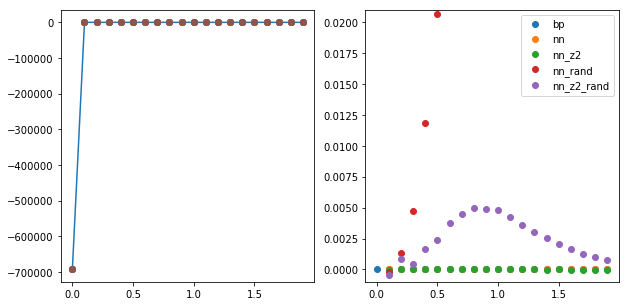

In [10]:
%matplotlib inline
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2,
                                          res_nn_rand, res_nn_z2_rand])
plt.ylim(-0.001,0.021)
plt.show()

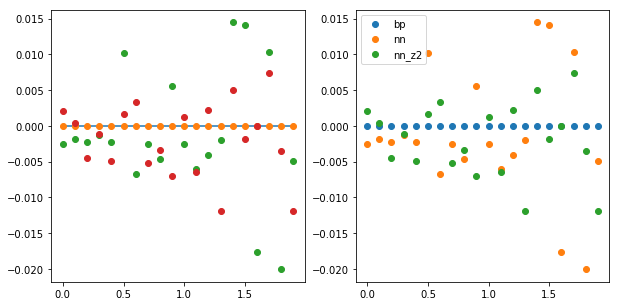

In [11]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()

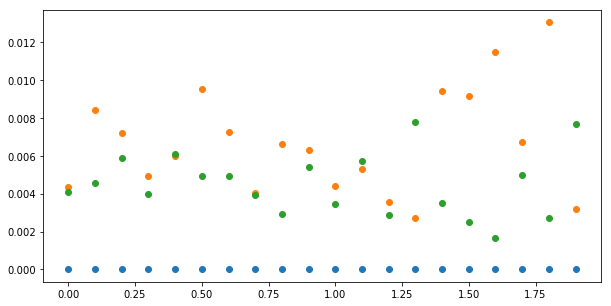

In [12]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn, res_nn_z2])
plt.show()

# With random field

In [13]:
H = np.random.random(N)
H_rand = H.copy()

for w in swaps:
    rev = list(reversed(w))
    H_rand[w] = H_rand[rev]


In [14]:
H_rand

array([0.64877229, 0.87260553, 0.33056533, 0.95956863, 0.76765142,
       0.9915353 , 0.24128155, 0.29241745, 0.14066889, 0.74389864,
       0.25750735, 0.15743139, 0.14038454])

In [15]:
H

array([0.64877229, 0.29241745, 0.14038454, 0.95956863, 0.74389864,
       0.14066889, 0.24128155, 0.87260553, 0.9915353 , 0.76765142,
       0.25750735, 0.15743139, 0.33056533])

In [16]:
tree = model.model(N, H, J, J_interaction)
tree_rand = model.model(N, H_rand, J_rand, J_interaction_rand)

res_ex = solvers.exact_sol(tree, betas_fast)

res_nn = solvers.nn_sol(tree, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn["name"]="nn"
res_nn_rand = solvers.nn_sol(tree_rand, betas_fast, max_step=500, bias = True, 
                        z2 = False, x_hat_clip = False)
res_nn_rand["name"]="nn_rand"

res_bp = solvers.bp_sol(tree, betas_fast)
res_bp["name"]="bp"

beta: 0.0, Fe: -693147.181 Energy: -1.28e-06 M: 5.03e-07 S: 0.693
beta: 0.1, Fe: -6.997 Energy: -0.135 M: 0.0612 S: 0.686
beta: 0.2, Fe: -3.604 Energy: -0.29 M: 0.151 S: 0.663
beta: 0.3, Fe: -2.529 Energy: -0.473 M: 0.274 S: 0.617
beta: 0.4, Fe: -2.040 Energy: -0.674 M: 0.421 S: 0.546
beta: 0.5, Fe: -1.787 Energy: -0.866 M: 0.567 S: 0.46
beta: 0.6, Fe: -1.647 Energy: -1.02 M: 0.687 S: 0.375
beta: 0.7, Fe: -1.566 Energy: -1.14 M: 0.775 S: 0.301
beta: 0.8, Fe: -1.518 Energy: -1.22 M: 0.837 S: 0.241
beta: 0.9, Fe: -1.488 Energy: -1.27 M: 0.88 S: 0.193
beta: 1.0, Fe: -1.468 Energy: -1.31 M: 0.911 S: 0.156
beta: 1.1, Fe: -1.455 Energy: -1.34 M: 0.933 S: 0.126
beta: 1.2, Fe: -1.447 Energy: -1.36 M: 0.949 S: 0.102
beta: 1.3, Fe: -1.441 Energy: -1.38 M: 0.961 S: 0.0826
beta: 1.4, Fe: -1.437 Energy: -1.39 M: 0.97 S: 0.067
beta: 1.5, Fe: -1.434 Energy: -1.4 M: 0.977 S: 0.0543
beta: 1.6, Fe: -1.432 Energy: -1.4 M: 0.982 S: 0.044
beta: 1.7, Fe: -1.430 Energy: -1.41 M: 0.986 S: 0.0357
beta: 1.8, Fe

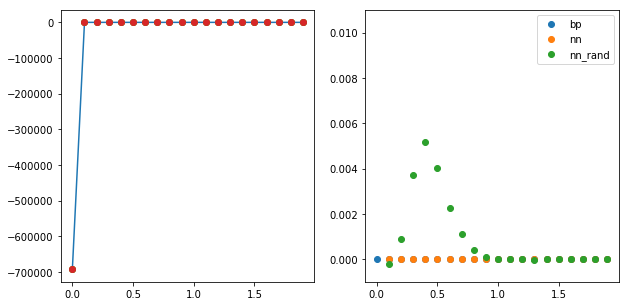

In [21]:
%matplotlib inline
label="fe"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_rand])
plt.ylim(-0.001,0.011)
plt.show()

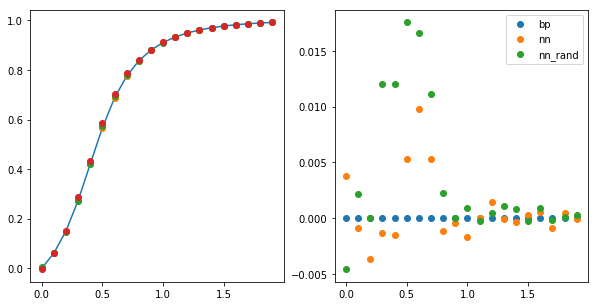

In [22]:
%matplotlib inline
label="M"
plt= solvers.plot_quantity(label, res_ex, [res_bp, res_nn, res_nn_rand])
plt.show()

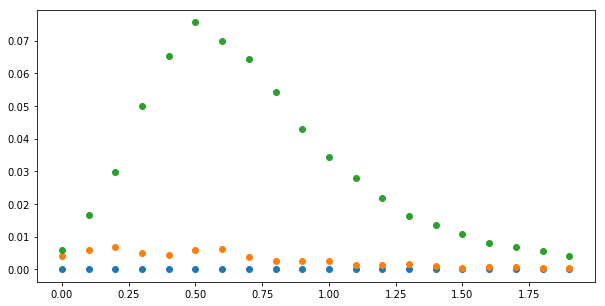

In [23]:
%matplotlib inline
label="M_i"
plt= solvers.plot_quantity_sum(label, res_ex, [res_bp, res_nn, res_nn_rand])
plt.show()